## Index

* [Introduction](#intro)
* [Preparation](#preparation)
* [Optimization](#optimization)
    * [Normalization](#normalization)
    * [Object detection](#object-detection)
    * [Dimensionality Reduction](#dimensionality-reduction)
* [Online Demo](#demo)

# Deep Dive into Real-World Image Search Engine with Towhee <a class="anchor" id="intro"></a>

In the [previous tutorial](./1_build_image_search_engine.ipynb), we built and prototyped a proof-of-concept image search engine. With test results from the previous tutorial, we find out that more complex model usually generates larger embeddings, hence leads to better search performance but slower speed.

Now, let's try some new methods to improve performance and save resource, other than changing model. At the end, we will also learn how to deploy it as a simple online demo. With this tutorial, you are able to build a reverse image search engine more practical in production.

## Preparation <a class="anchor" id="preparation"></a>

Here is a table of search performance with different models from the previous tutorial. We will make some improvement in pipelines and compare model performance in this tutorial. Before getting started, we need to prepare dependencies, example data, and helpful functions, which have detailed explanation in the previous tutorial.

| model | dim | mAP@10 | qps |
| -- | -- | -- | -- |
| vgg16 | 512 | 0.658 | 53 |
| resnet50 | 2048 | 0.886 | 35 |
| tf_efficientnet_b7 | 2560 | 0.983 | 16 |

**Install dependencies**: install python dependencies with proper versions for your environment.

In [1]:
! python -m pip -q install towhee gradio==3.3 opencv-python

**Prepare data**: download example data, which is a subset of [ImageNet](https://www.image-net.org/).

In [2]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip

**Start Milvus:** install and start Milvus service.

This notebook uses [milvus 2.2.10](https://milvus.io/docs/v2.2.x/install_standalone-docker.md) and [pymilvus 2.2.11](https://milvus.io/docs/release_notes.md#2210).

In [3]:
! wget https://github.com/milvus-io/milvus/releases/download/v2.2.10/milvus-standalone-docker-compose.yml -O docker-compose.yml
! docker-compose up -d
! python -m pip install -q pymilvus==2.2.11

**Helpful functions**: import necessary packages, set parameters, and build helpful functions in advance.

In [4]:
import cv2
import numpy
import time
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee import pipe, ops, DataCollection
from towhee.types.image import Image
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

# Towhee parameters
MODEL = 'vgg16'
DEVICE = None # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = '127.0.0.1'
PORT = '19530'
TOPK = 10
DIM = 512 # dimension of embedding extracted, change with MODEL
COLLECTION_NAME = 'deep_dive_image_search_' + MODEL
INDEX_TYPE = 'IVF_FLAT'
METRIC_TYPE = 'L2'

# patterns of image paths
INSERT_SRC = './train/*/*.JPEG'
QUERY_SRC = './test/*/*.JPEG'

to_insert = glob(INSERT_SRC)
to_test = glob(QUERY_SRC)

# Create milvus collection (delete first if exists)
def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE,
        'params': {"nlist": 2048}
    }
    collection.create_index(field_name='embedding', index_params=index_params)
    return collection
            
# Read images
decoder = ops.image_decode('rgb').get_op()
def read_images(img_paths):
    imgs = []
    for p in img_paths:
        img = decoder(p)
        imgs.append(img)
#         imgs.append(Image(cv2.imread(p), 'RGB'))
    return imgs

# Get ground truth
def ground_truth(path):
    train_path = str(Path(path).parent).replace('test', 'train')
    return [str(Path(x).resolve()) for x in glob(train_path + '/*.JPEG')]

# Calculate Average Precision
def get_ap(pred: list, gt: list):
    ct = 0
    score = 0.
    for i, n in enumerate(pred):
        if n in gt:
            ct += 1
            score += (ct / (i + 1))
    if ct == 0:
        ap = 0
    else:
        ap = score / ct
    return ap

## Optimization <a class="anchor" id="optimization"></a>

In the previous tutorial, we have measured the search performance with **mAP** and compared performance for different models. This tutorial will show how to improve performance by normalization, implement pipeline with object detection, and reduce dimension to save resource. 

### Normalization <a class="anchor" id="normalization"></a>

A quick optimization is normalizing the embedding features before indexing them in Milvus. Thus, the L2 metric used by Milvus is equivalent to cosine similarity, which measures the similarity using the angle between vectors while ignoring the magnitude of vectors.

In [5]:
# Embedding pipeline
p_embed = (
    pipe.input('img_path')
        .map('img_path', 'img', ops.image_decode('rgb'))
        .map('img', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
        .map('vec', 'vec', lambda x: x / numpy.linalg.norm(x, axis=0))
)

img_path,img,vec
./train/parachute/n03888257_31784.JPEG,,"[0.018488767, 0.069933996, 0.00011331425, ...] shape=(512,)"

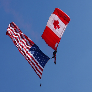

In [6]:
# Display embedding result, no need for implementation
p_display = p_embed.output('img_path', 'img', 'vec')

DataCollection(p_display(to_insert[0])).show()

Now we have an embedding pipeline extracting normalized vectors for images. Let's build a image search engine based on the embedding pipeline and Milvus collection. We evaluate the engine by inserting candidate data and querying test images. The result table below shows mAP increases for all models. This proves that normalization is able to improve image search.

In [7]:
# Connect to Milvus service
connections.connect(host=HOST, port=PORT)

# Create collection
collection = create_milvus_collection(COLLECTION_NAME, DIM)
print(f'A new collection created: {COLLECTION_NAME}')

# Insert data
p_insert = (
        p_embed.map(('img_path', 'vec'), 'mr', ops.ann_insert.milvus_client(
                    host=HOST,
                    port=PORT,
                    collection_name=COLLECTION_NAME
                    ))
          .output('mr')
)

for img_path in to_insert:
    p_insert(img_path)
print('Number of data inserted:', collection.num_entities)

# Performance
collection.load()
p_search_pre = (
        p_embed.map('vec', ('search_res'), ops.ann_search.milvus_client(
                    host=HOST, port=PORT, limit=TOPK,
                    collection_name=COLLECTION_NAME))
               .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
#                .output('img_path', 'pred')
)
p_eval = (
    p_search_pre.map('img_path', 'gt', ground_truth)
                .map(('pred', 'gt'), 'ap', get_ap)
                .output('ap')
)

res = []
for img_path in to_test:
    ap = p_eval(img_path).get()[0]
    res.append(ap)

mAP = mean(res)

print(f'mAP@{TOPK}: {mAP}')

A new collection created: deep_dive_image_search_vgg16


E0209 17:36:01.144905126   63043 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0209 17:36:01.296288564   60015 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Number of data inserted: 1000
mAP@10: 0.7381725828294281


| model | mAP@10 (no norm) | mAP@10 (norm) |
| -- | -- | -- |
| vgg16 | 0.658 | 0.738 |
| resnet50 | 0.886 | 0.917 |
| tf_efficientnet_b7 | 0.983 | 0.988 |

###  Object Detection <a class="anchor" id="object-detection"></a>

Another common option in reverse image search is object detection. Sometimes the search engine is distracted by small objects or background in the image. Cropping the original image and querying only the main object help to resolve this issue.

Let's take a look at a bad search. With normalized embeddings extracted by `vgg16`, the test image *'./test/rocking_chair/n04099969_23803.JPEG'* gets a list of similar images containing some incorrect results, which has an Average Precision of 0.347.

E0209 17:36:52.111067087   67628 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


img_path,img,res,ap
./test/rocking_chair/n04099969_23803.JPEG,,,0.34722222222222215

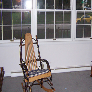
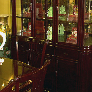
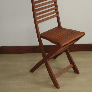
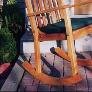
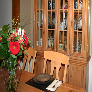
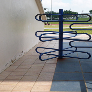
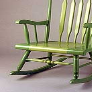
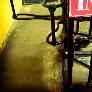
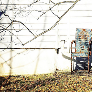
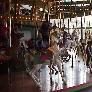
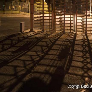

In [8]:
p_search_img = (
    p_search_pre.map('img_path', 'gt', ground_truth)
                .map(('pred', 'gt'), 'ap', get_ap)
                .map('pred', 'res', read_images)
                .output('img_path', 'img', 'res', 'ap')
)
DataCollection(p_search_img('./test/rocking_chair/n04099969_23803.JPEG')).show()

Now let's preprocess the test image by focusing on the main object in it. Here we use YOLOv5 to get objects in the image. We select the object with the largest area in the original image, and then search across database with the object image.

- `get_object`: a function to get the image of the largest object detecte, or the original imageif there is no object
- `p_yolo`: a pipeline to crop the largest object in the given image

In [9]:
def get_max_object(img, boxes):
    if len(boxes) == 0:
        return img
    max_area = 0
    for box in boxes:
        x1, y1, x2, y2 = box
        area = (x2-x1)*(y2-y1)
        if area > max_area:
            max_area = area
            max_img = img[y1:y2,x1:x2,:]
    return max_img

p_yolo = (
    pipe.input('img_path')
        .map('img_path', 'img', ops.image_decode('rgb'))
        .map('img', ('boxes', 'class', 'score'), ops.object_detection.yolov5())
        .map(('img', 'boxes'), 'object', get_max_object)
)

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


Using cache found in /home/data3/cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-30 Python-3.9.12 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12054MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


img,object
,

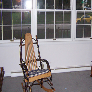
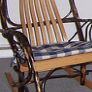

In [10]:
# Display embedding result, no need for implementation
p_display = (
    p_yolo.output('img', 'object')
)
DataCollection(p_display('./test/rocking_chair/n04099969_23803.JPEG')).show()

With object detection, we search for *'./test/rocking_chair/n04099969_23803.JPEG'* again across the same Milvus collection. The average precision has increased by about 45%. It is a great improvement for this query.

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


Using cache found in /home/data3/cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-30 Python-3.9.12 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12054MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
E0209 17:37:09.336641703   60015 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0209 17:37:09.455251735   68535 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


img,object,res,ap
,,,0.775

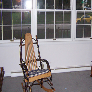
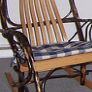
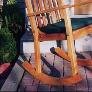
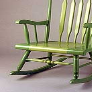
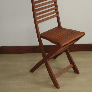
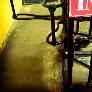
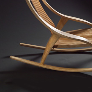
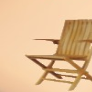
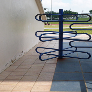
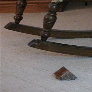
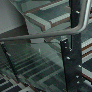
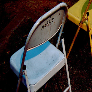

In [11]:
# Search
p_search_pre_yolo = (
    p_yolo.map('object', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
          .map('vec', 'vec', lambda x: x / numpy.linalg.norm(x, axis=0))
          .map('vec', ('search_res'), ops.ann_search.milvus_client(
                host=HOST, port=PORT, limit=TOPK,
                collection_name=COLLECTION_NAME))
          .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
#          .output('img_path', 'pred')
)

# Evaluate with AP
p_search_img_yolo = (
    p_search_pre_yolo.map('img_path', 'gt', ground_truth)
                     .map(('pred', 'gt'), 'ap', get_ap)
                     .map('pred', 'res', read_images)
                     .output('img', 'object', 'res', 'ap')
)
DataCollection(p_search_img_yolo('./test/rocking_chair/n04099969_23803.JPEG')).show()

### Dimensionality Reduction <a class="anchor" id="dimensionality-reduction"></a>

For a system in production, it is practical to mimimize the embedding dimension in order to reduce memory consumption. [Random projection](https://en.wikipedia.org/wiki/Random_projection) is a dimensionality reduction method for a set vectors in Euclidean space. This method is fast and requires no training. Let's try it with the model `EfficientNet-B7`, which generates embeddings of a high dimension 2560.

In [12]:
NEW_MODEL = 'tf_efficientnet_b7'
OLD_DIM = 2560
NEW_DIM = 512
NEW_COLLECTION_NAME = NEW_MODEL + '_' + str(NEW_DIM)

numpy.random.seed(2023)
projection_matrix = numpy.random.normal(scale=1.0, size=(OLD_DIM, NEW_DIM))

def dim_reduce(vec):
    return numpy.dot(vec, projection_matrix)

connections.connect(host=HOST, port=PORT)
new_collection = create_milvus_collection(NEW_COLLECTION_NAME, NEW_DIM)
print(f'A new collection created: {NEW_COLLECTION_NAME}')


# Embedding pipeline
p_embed = (
    pipe.input('img_path')
        .map('img_path', 'img', ops.image_decode('rgb'))
        .map('img', 'vec', ops.image_embedding.timm(model_name=NEW_MODEL, device=DEVICE))
        .map('vec', 'vec', dim_reduce)
)

A new collection created: tf_efficientnet_b7_512


img_path,img,vec
./train/parachute/n03888257_31784.JPEG,,"[-3.1598568204094115, -6.1017211401300315, -16.71238753352162, ...] shape=(512,)"

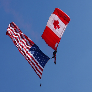

In [13]:
# Display embedding result, no need for implementation
p_display = p_embed.output('img_path', 'img', 'vec')

DataCollection(p_display(to_insert[0])).show()

We've build a new embedding pipeline converts each image into a vector of reduced dimension. Insert and search pipelines are built on top of the embedding pipeline, like what we did in previous sections. We can apply the same evaluation method to this engine.

The dimension of embedding vector is reduced from 2560 to 512, thereby reducing memory usage by 80%. Despite this, it maintains a reasonable performance (97% mAP for reduced vectors vs 98.3% for full vectors).

In [14]:
# Insert pipeline
p_insert = (
        p_embed.map(('img_path', 'vec'), 'mr', ops.ann_insert.milvus_client(
                    host=HOST,
                    port=PORT,
                    collection_name=NEW_COLLECTION_NAME
                    ))
          .output('mr')
)

# Insert data
for img_path in to_insert:
    p_insert(img_path)
print('Number of data inserted:', new_collection.num_entities)

# Search pipeline
new_collection.load()
p_search_pre = (
        p_embed.map('vec', 'search_res', ops.ann_search.milvus_client(
                    host=HOST, port=PORT, limit=TOPK,
                    collection_name=NEW_COLLECTION_NAME))
               .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
#                .output('img_path', 'pred')
)

# Performance
p_eval = (
    p_search_pre.map('img_path', 'gt', ground_truth)
                .map(('pred', 'gt'), 'ap', get_ap)
                .output('ap')
)

res = []
for img_path in to_test:
    ap = p_eval(img_path).get()[0]
    res.append(ap)

mAP = mean(res)

print(f'mAP@{TOPK}: {mAP}')

Number of data inserted: 1000
mAP@10: 0.9700658698664651


## Online Demo <a class="anchor" id="demo"></a>

This section shows how to use Gradio to build a simple showcase with user interface. With Gradio, we simply need to wrap the data processing pipeline via a f_search function. Please note here we search across a prepared Milvus collection *'deep_dive_image_search_vgg16'*, which stores normalized image embeddings extracted by vgg16.

In [15]:
import gradio

DEMO_MODEL = 'vgg16'
DEMO_COLLECTION = 'deep_dive_image_search_' + DEMO_MODEL

def f_search(img):
    p_search = (
        pipe.input('img')
            .map('img', 'vec', ops.image_embedding.timm(model_name=DEMO_MODEL, device=DEVICE))
            .map('vec', 'vec', lambda x: x / numpy.linalg.norm(x, axis=0))
            .map('vec', 'search_res', ops.ann_search.milvus_client(
                    host=HOST, port=PORT, limit=TOPK,
                    collection_name=DEMO_COLLECTION))
            .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
            .output('pred')
    )
    return p_search(img).get()[0]

interface = gradio.Interface(f_search, 
                             gradio.inputs.Image(type="pil", source='upload'),
                             [gradio.outputs.Image(type="file", label=None) for _ in range(TOPK)]
                            )

interface.launch(inline=True, share=True)

IMPORTANT: You are using gradio version 3.3, however version 3.14.0 is available, please upgrade.
--------
Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://c5d025b17a1dac43.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://www.huggingface.co/spaces


(<gradio.routes.App at 0x7f45600d9280>,
 'http://127.0.0.1:7860/',
 'https://c5d025b17a1dac43.gradio.app')

## Explore Towhee

- Built-in pipelines for various tasks
- Microservice & onnx acceleration powered by TritonServe
- Docker image with everything ready